# FCA analysis - annotate clusters and identify DEGs

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
import glob
import matplotlib.pyplot as pl

def Barplot(which_var, adata, var='clusters_manual', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)
    


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_manual_annotation/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
google              NA
h5py                2.10.0
idna                2.10
igraph              0.9.1
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.

'/opt/conda/bin/python'

## Load data

In [2]:
adata = sc.read('FCA-M3clusters.h5ad')
adata.X.shape

(319081, 28037)

In [3]:
# Add cluster name and doublet information
clu_annot = pd.read_csv('figures_manual_annotation/clustering_metadata.csv', header=0, index_col=0)
import collections 

if collections.Counter(adata.obs.index) == collections.Counter(clu_annot.index): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 
    
vars2import = ['clusters_manual','louvain', 'is_doublet', 'scrublet_cluster_score', 'scrublet_score']
for var in vars2import:
    adata.obs[var] = clu_annot[var]

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The lists are identical


In [4]:
set(adata.obs['clusters_manual'] )

{'Coel Epi',
 'Doublets',
 'Endothelial',
 'Epithelial',
 'Erythroid',
 'Germ cells',
 'Immune',
 'Mesenchymal_GATA2_NR2F1',
 'Mesenchymal_LHX9_ARX',
 'Metanephros',
 'Neural',
 'PV',
 'Sertoli',
 'Supporting_female',
 'lowQC'}

# Import supporting and mesenchymal

In [33]:
supporting = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_annotation_doublets.csv', index_col = 0)
print(supporting['annotated_clusters'].value_counts())
supporting = supporting[supporting['annotated_clusters'].isin(['coelEpi', 'sKITLG', 'sLGR5', 'sPAX8', 'preGC_I_OSR1',
                                                        'ovarianSurf', 'preGC_II_KITLG', 'preGC_III_GJA1',
                                                       'Sertoli_WFDC2', 'Sertoli', 'Sertoli_low'])]
print(supporting['annotated_clusters'].value_counts())

mask1 = np.array([i in 'sLGR5' for i in supporting['annotated_clusters']])
supporting.loc[mask1, 'annotated_clusters'] = 'sLGR5_female'
print(supporting['annotated_clusters'].value_counts())

mask2 = np.array([i in 'male' for i in supporting['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
supporting.loc[mask, 'annotated_clusters'] = 'sLGR5_male'
print(supporting['annotated_clusters'].value_counts())

Sertoli            18930
preGC_II_KITLG     14105
preGC_III_GJA1     13520
preGC_I_OSR1       10768
Sertoli_low         9237
cycling             4874
ovarianSurf         4851
coelEpi             4281
Oi-like             4242
Sertoli_cycling     4103
lowQC_I             3839
sPAX8               3412
doublet_I           2473
sLGR5               2454
Sertoli_WFDC2       1024
lowQC_II            1007
coelEpi_cycling     1000
lowQC_III            968
sKITLG               903
doublet_II           759
FetalLeydig          386
lowQC_IV             112
Name: annotated_clusters, dtype: int64
Sertoli           18930
preGC_II_KITLG    14105
preGC_III_GJA1    13520
preGC_I_OSR1      10768
Sertoli_low        9237
ovarianSurf        4851
coelEpi            4281
sPAX8              3412
sLGR5              2454
Sertoli_WFDC2      1024
sKITLG              903
Name: annotated_clusters, dtype: int64
Sertoli           18930
preGC_II_KITLG    14105
preGC_III_GJA1    13520
preGC_I_OSR1      10768
Sertoli_low 

In [34]:
mesenchymal = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymal_annotated.csv', index_col = 0)
print(mesenchymal['annotated_clusters'].value_counts())
mesenchymal = mesenchymal[mesenchymal['annotated_clusters'].isin(['FetalLeydig', 'Ti', 'Oi', 'Gi'])]
print(mesenchymal['annotated_clusters'].value_counts())

M_MGP               26162
Ti                  24745
M_cycling           16376
Gi                  14846
Oi                  11900
M_MullDuct_LGR5      6811
M_prog_ISL1          5021
M_ALX1               4625
M_MullDuct_AMHR2     3318
FetalLeydig          2368
Name: annotated_clusters, dtype: int64
Ti             24745
Gi             14846
Oi             11900
FetalLeydig     2368
Name: annotated_clusters, dtype: int64


In [35]:
germ = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotation.csv', index_col = 0)
print(germ['annotated_clusters'].value_counts())
germ = germ[germ['annotated_clusters'].isin(['PGC', 'PGC_mitotic', 'GC_mitotic',
                                             'oogonia_STRA8', 'oogonia_meiosis', 'oocyte',
                                            'pre-spermatogonia'])]
print(germ['annotated_clusters'].value_counts())

PGC                  2011
oogonia_meiosis      1852
oogonia_STRA8        1672
oocyte                919
PGC_mitotic           869
GC_mitotic            793
pre-spermatogonia     753
Name: annotated_clusters, dtype: int64
PGC                  2011
oogonia_meiosis      1852
oogonia_STRA8        1672
oocyte                919
PGC_mitotic           869
GC_mitotic            793
pre-spermatogonia     753
Name: annotated_clusters, dtype: int64


In [36]:
epi = pd.read_csv('/nfs/team292/lg18/with_valentina/epithelial_annotation.csv', index_col = 0)
print(epi['annotated_clusters'].value_counts())
epi = epi[epi['annotated_clusters'].isin(['Epi_MullDuct', 'Epi_MesoDuct_CUBN', 'Epi_GATA3', 'Epi_MesoDuct_TFAP2B', 'Epididymis'])]
print(epi['annotated_clusters'].value_counts())

Epi_MullDuct           4644
Epi_MesoDuct_CUBN      1501
Epi_cycling             816
Epi_GATA3               595
Epi_MesoDuct_TFAP2B     337
Epididymis              289
Name: annotated_clusters, dtype: int64
Epi_MullDuct           4644
Epi_MesoDuct_CUBN      1501
Epi_GATA3               595
Epi_MesoDuct_TFAP2B     337
Epididymis              289
Name: annotated_clusters, dtype: int64


In [37]:
supporting_mesenchymal = supporting.append(mesenchymal)
supporting_mesenchymal = supporting_mesenchymal.append(germ)
supporting_mesenchymal = supporting_mesenchymal.append(epi)
mapping_dict = supporting_mesenchymal['annotated_clusters'].to_dict()
adata.obs['annotated_clusters'] = adata.obs_names.map(mapping_dict)
adata.obs['annotated_clusters'].value_counts(dropna = False)

NaN                    107178
Ti                      24745
Sertoli                 18930
Gi                      14846
preGC_II_KITLG          14105
preGC_III_GJA1          13520
Oi                      11900
preGC_I_OSR1            10768
Sertoli_low              9237
ovarianSurf              4851
Epi_MullDuct             4644
coelEpi                  4281
sPAX8                    3412
FetalLeydig              2368
sLGR5_female             2183
PGC                      2011
oogonia_meiosis          1852
oogonia_STRA8            1672
Epi_MesoDuct_CUBN        1501
Sertoli_WFDC2            1024
oocyte                    919
sKITLG                    903
PGC_mitotic               869
GC_mitotic                793
pre-spermatogonia         753
Epi_GATA3                 595
Epi_MesoDuct_TFAP2B       337
Epididymis                289
sLGR5_male                271
Name: annotated_clusters, dtype: int64

In [38]:
# Replace NaN with big clusters 
adata.obs['annotated_clusters'] = adata.obs['annotated_clusters'].fillna(adata.obs['clusters_manual'])
adata.obs['annotated_clusters'].value_counts(dropna = False)

Mesenchymal_GATA2_NR2F1    63684
Sertoli                    27423
Ti                         24745
Gi                         14846
preGC_II_KITLG             14105
preGC_III_GJA1             13520
Oi                         11900
Endothelial                10948
preGC_I_OSR1               10768
Sertoli_low                 9237
PV                          7440
Erythroid                   7423
Immune                      5157
ovarianSurf                 4851
Epi_MullDuct                4644
coelEpi                     4281
sPAX8                       3412
Neural                      2530
FetalLeydig                 2368
sLGR5_female                2183
PGC                         2011
oogonia_meiosis             1852
oogonia_STRA8               1672
Metanephros                 1503
Epi_MesoDuct_CUBN           1501
Sertoli_WFDC2               1024
oocyte                       919
sKITLG                       903
PGC_mitotic                  869
GC_mitotic                   793
pre-sperma

In [39]:
# Clean cells
set(adata.obs['annotated_clusters'] )
adata = adata[[ 'oublet' not in i for i in adata.obs['annotated_clusters'] ]]
adata = adata[[ 'cycling' not in i for i in adata.obs['annotated_clusters'] ]]
adata = adata[[ i  not in ['Coel Epi', 'lowQC', 'Epithelial', 'Supporting_female' , 'Germ cells', 'Mesenchymal_LHX9_ARX'] for i in adata.obs['annotated_clusters'] ]]
set(adata.obs['annotated_clusters'] )

{'Endothelial',
 'Epi_GATA3',
 'Epi_MesoDuct_CUBN',
 'Epi_MesoDuct_TFAP2B',
 'Epi_MullDuct',
 'Epididymis',
 'Erythroid',
 'FetalLeydig',
 'GC_mitotic',
 'Gi',
 'Immune',
 'Mesenchymal_GATA2_NR2F1',
 'Metanephros',
 'Neural',
 'Oi',
 'PGC',
 'PGC_mitotic',
 'PV',
 'Sertoli',
 'Sertoli_WFDC2',
 'Sertoli_low',
 'Ti',
 'coelEpi',
 'oocyte',
 'oogonia_STRA8',
 'oogonia_meiosis',
 'ovarianSurf',
 'pre-spermatogonia',
 'preGC_III_GJA1',
 'preGC_II_KITLG',
 'preGC_I_OSR1',
 'sKITLG',
 'sLGR5_female',
 'sLGR5_male',
 'sPAX8'}

In [41]:
adata.obs['cells'] = pd.Series(adata.obs['annotated_clusters'], dtype="category")
adata.obs['cells'].cat.reorder_categories(['PGC', 'PGC_mitotic', 'GC_mitotic',
                                             'oogonia_STRA8', 'oogonia_meiosis', 'oocyte',
                                            'pre-spermatogonia',
                                            'coelEpi',  'sKITLG', 'sLGR5_male','sLGR5_female', 'sPAX8', 'preGC_I_OSR1',
                                            'ovarianSurf','preGC_II_KITLG', 'preGC_III_GJA1',
                                             'Sertoli_WFDC2', 'Sertoli', 'Sertoli_low',
                                           'FetalLeydig', 'Ti',  'Oi',  'Gi', 
                                            'Mesenchymal_GATA2_NR2F1', 
                                           'Epi_MullDuct', 'Epi_MesoDuct_CUBN', 'Epi_GATA3', 'Epi_MesoDuct_TFAP2B', 'Epididymis',    
                                          'PV','Endothelial', 'Immune', 'Erythroid', 'Metanephros', 'Neural' ], inplace=True)

... storing 'annotated_clusters' as categorical


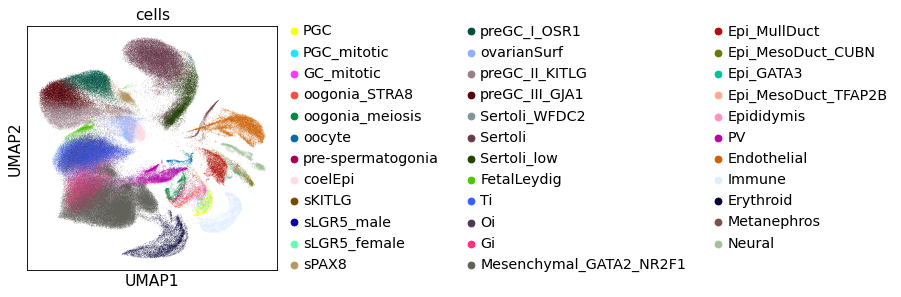

In [42]:
sc.pl.umap(adata, color='cells')

# Mesenchymal TFs

In [43]:
marker_genes = {
    'PGCs': { 'NANOG', 'NANOS3', 'KIT'},
#     'GCs': {'DAZL', 'DDX4'}, 
    'Mesothelial': {'LRRN4', 'LHX2', 'KLK11'},
    'Supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'preGranulosa':{"KITLG", 'FOXL2'},
    'Sertoli': {'SOX9', 'AMH', 'INHA'},
    'Mesenchymal':{'DCN', 'PDGFRA', 'COL1A1'},
    'gonadal':{'GATA4', 'LHX9', 'ARX'},
    'extragonadal':{'GATA2', 'NR2F1'},
    'PV': {"PDGFRB", 'ACTA2'},
    'Epithelial': {"EPCAM", 'PAX8'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'Immune': {'PTPRC', 'CD68'},
    'Erythroid': {"GYPC", "HBA1"},
    'Metanephros': {"NPHS2", "CLIC5", "PTPRO"},
    'Neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'}
}

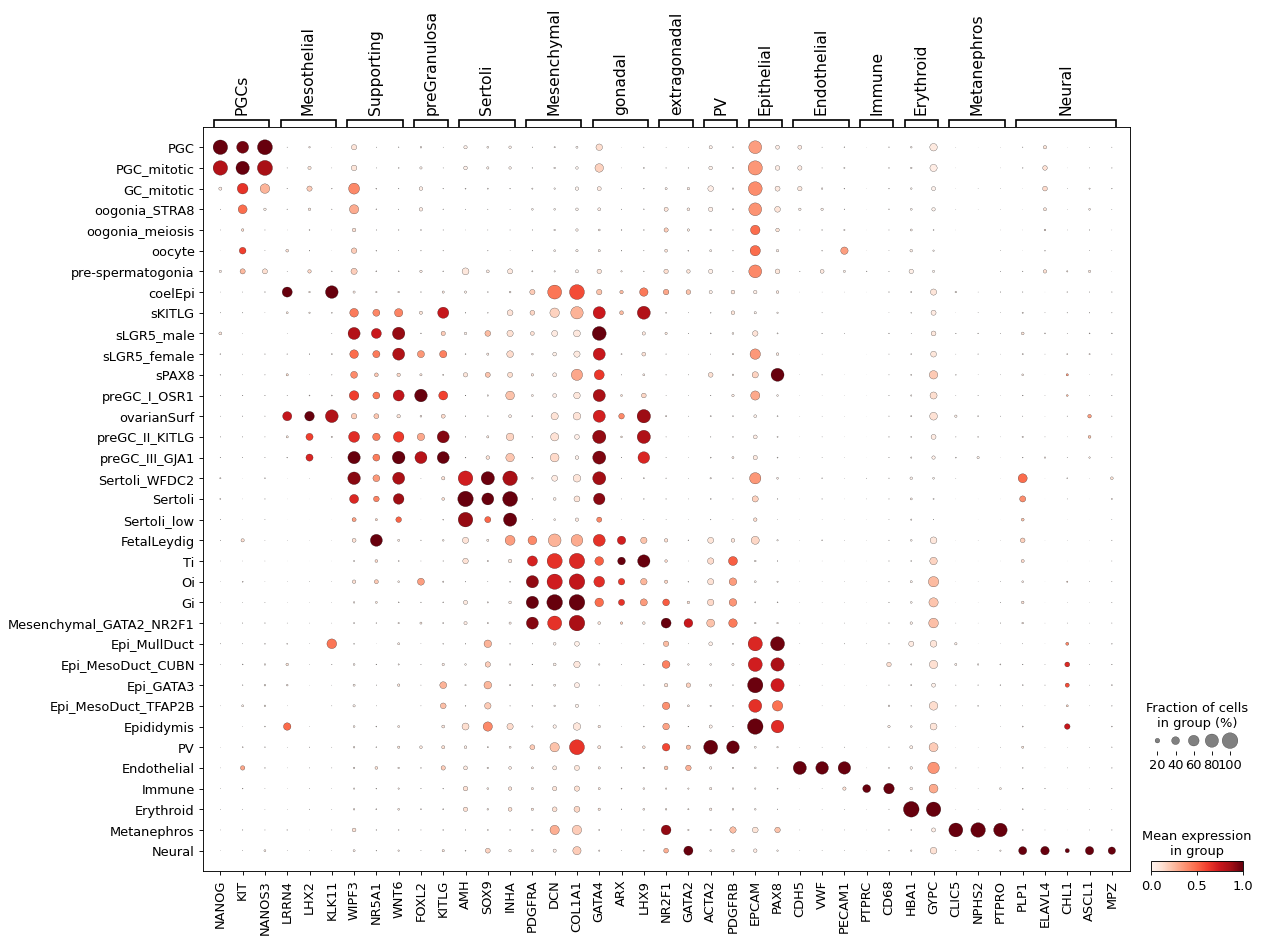

In [44]:
# adata.obs['cells'].cat.reorder_categories(adata.obs['cells'].cat.categories[::-1], inplace=True)
sc.pl.dotplot(adata, marker_genes, groupby='cells', use_raw=False, standard_scale = 'var')


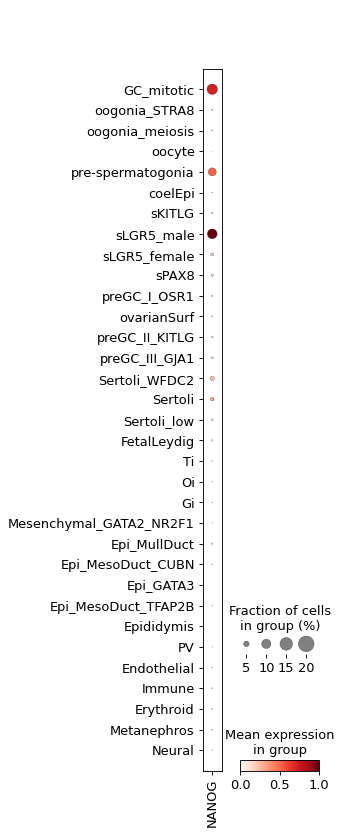

In [46]:
sc.pl.dotplot(adata[[ "PGC" not in i for i in adata.obs['cells']  ]], ["NANOG"], groupby='cells', use_raw=False, standard_scale = 'var')

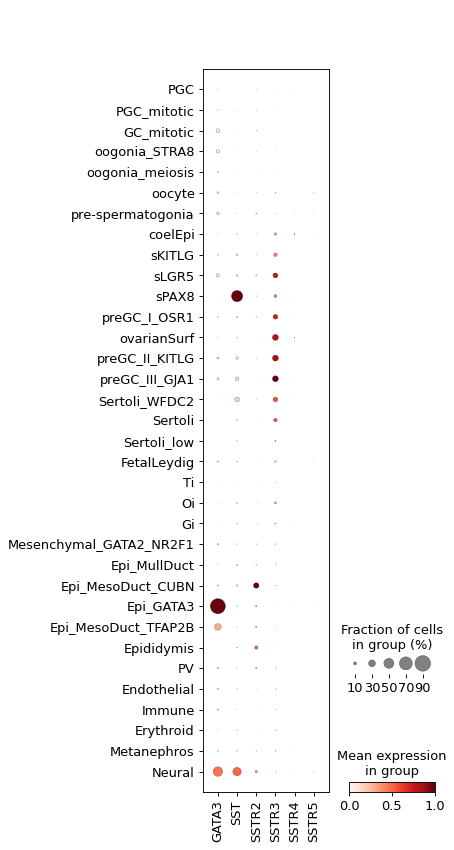

In [17]:
sc.pl.dotplot(adata, ['GATA3', 'SST', 'SSTR2', 'SSTR3', 'SSTR4', 'SSTR5'], groupby='cells', use_raw=False, standard_scale = 'var')

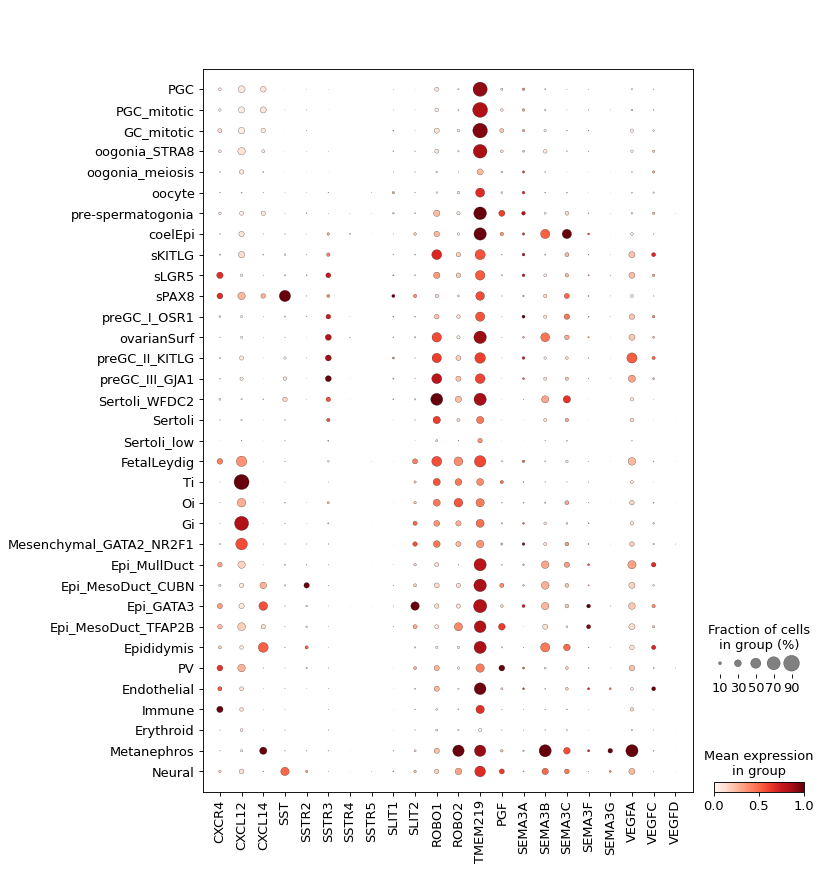

In [18]:
sc.pl.dotplot(adata, ['CXCR4','CXCL12', 'CXCL14', 'SST', 'SSTR2', 'SSTR3', 'SSTR4', 'SSTR5', 'SLIT1', 'SLIT2','ROBO1', 'ROBO2', 'TMEM219',
                     'PGF', 'SEMA3A', 'SEMA3B', 'SEMA3C', 'SEMA3F', 'SEMA3G', 'VEGFA', 'VEGFC', 'VEGFD'], groupby='cells', use_raw=False, standard_scale = 'var')

In [ ]:
DSD = pd.read_csv('DSD_genes.csv', header=None, index_col=0)
DSD.head()
genes_d = DSD.index.tolist()

# from itertools import chain
genes_d = set(genes_d)
genes = [i  for i in genes_d if i in adata.raw.var_names]

In [ ]:
sc.pl.dotplot(adata, sorted(genes), groupby='cells', use_raw=True, standard_scale = 'var', save='_DSD.pdf')

In [ ]:
GWAS = pd.read_csv('/nfs/team292/vl6/GWAS_gonads/GWAS_PCOS.csv', header=0, index_col=0)
GWAS.head()
genes_d = GWAS['Mapped gene'].tolist()
genes = [ i.split(', ') for i in genes_d ]

from itertools import chain
genes =  set(chain(*genes))
genes = [i  for i in genes if i in adata.raw.var_names]

In [ ]:
sc.pl.dotplot(adata, sorted(genes), groupby='cells', use_raw=False, standard_scale = 'var', save='_GWAS_ovarian_populations.pdf')